In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from modellib.attention import Attention
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

plt.rcParams.update({'font.size': 16})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

2023-04-26 07:15:35.453496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 07:15:35.491378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 07:15:35.492244: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 07:15:36.105163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with open('./logs/data/dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [3]:
def ATT(input_shape):
    inp=tf.keras.layers.Input(input_shape)
    net=Attention((None,*input_shape))(inp)
    out=tf.keras.layers.Dense(units=256,activation="relu")(net)
    att_model=tf.keras.Model(inputs=inp,outputs=out,name="ATT")
    return att_model

def CNN(input_shape):
    cnn_model=\
    tf.keras.Sequential([
        tf.keras.layers.Conv2D(64,(5,5),(2,2),"same",activation="relu",input_shape=input_shape),
        tf.keras.layers.Conv2D(128,(3,3),(2,2),"same",activation="relu"),
        tf.keras.layers.Conv2D(256,(3,3),(2,2),"same",activation="relu"),
        tf.keras.layers.GlobalAveragePooling2D(),
    ],name='CNN')
    return cnn_model

def ANN(input_shape):
    ann_model=\
    tf.keras.Sequential([
        tf.keras.layers.Dense(units=256,activation="relu",input_shape=input_shape),
        tf.keras.layers.Dense(units=64,activation="relu"),
        tf.keras.layers.Dense(units=1,activation="linear")
    ],name='ANN')
    return ann_model

In [4]:
#FUSED MODEL

In [5]:
X_seq=tf.keras.layers.Input(shape=(10,21))
X_img=tf.keras.layers.Input(shape=(64,64,3))

cnn=CNN((64,64,3))
att=ATT((10,21))
ann=ANN((512,))

cnn_emb=cnn(X_img)
att_emb=att(X_seq)
net=tf.concat([cnn_emb,att_emb],axis=1)
out=ann(net)

fused_model=tf.keras.Model(inputs=[X_seq,X_img],outputs=out,name='FUSED')

In [6]:
fused_model.summary()

Model: "FUSED"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 21)]     0           []                               
                                                                                                  
 CNN (Sequential)               (None, 256)          373888      ['input_2[0][0]']                
                                                                                                  
 ATT (Functional)               (None, 256)          5663        ['input_1[0][0]']                
                                                                                              

In [7]:
smax=np.max(dataset["seq"],axis=0)
smin=np.min(dataset["seq"],axis=0)
seq_scaled=np.float32((dataset["seq"]-smin)/(smax-smin))
img_scaled=np.float32(dataset['img']/255.)

speed=np.float32(dataset["spd"].reshape(-1,1))

In [8]:
train_idx=(np.array(dataset["tno"])==2019) #2019 is train data
test_idx=(np.array(dataset["tno"])==2018)  #2018 is test data

In [9]:
seq_train=seq_scaled[train_idx]
img_train=img_scaled[train_idx]
speed_train=speed[train_idx]
seq_test=seq_scaled[test_idx]
img_test=img_scaled[test_idx]
speed_test=speed[test_idx]

In [10]:
#Training
fused_model.compile(loss="mse",optimizer="adam",metrics=["mae","mse"])
best_save=tf.keras.callbacks.ModelCheckpoint(filepath="./logs/model/tr2019.h5",
                                             save_weights_only=True,
                                             monitor='val_mae',mode='max',
                                             save_best_only=True)

In [11]:
# fused_model.load_weights("./logs/model/overall.h5")
training=fused_model.fit(x=[seq_train,img_train],y=speed_train,batch_size=64,epochs=50,
                         validation_split=0.2,callbacks=[best_save])

Epoch 1/50


2023-04-26 07:16:00.459314: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 271810560 exceeds 10% of free system memory.


87/87 [==============================] - 11s 113ms/step - loss: 189.2706 - mae: 10.3207 - mse: 189.2706 - val_loss: 80.4789 - val_mae: 6.8385 - val_mse: 80.4789
Epoch 2/50
87/87 [==============================] - 10s 115ms/step - loss: 79.0605 - mae: 6.9318 - mse: 79.0605 - val_loss: 60.8338 - val_mae: 6.0446 - val_mse: 60.8338
Epoch 3/50
87/87 [==============================] - 14s 164ms/step - loss: 63.4607 - mae: 6.2001 - mse: 63.4607 - val_loss: 54.6303 - val_mae: 5.7149 - val_mse: 54.6303
Epoch 4/50
87/87 [==============================] - 11s 132ms/step - loss: 57.0574 - mae: 5.8744 - mse: 57.0574 - val_loss: 51.9347 - val_mae: 5.5860 - val_mse: 51.9347
Epoch 5/50
87/87 [==============================] - 10s 111ms/step - loss: 52.2917 - mae: 5.5771 - mse: 52.2917 - val_loss: 46.0202 - val_mae: 5.2221 - val_mse: 46.0202
Epoch 6/50
87/87 [==============================] - 9s 108ms/step - loss: 48.9987 - mae: 5.3995 - mse: 48.9987 - val_loss: 47.8756 - val_mae: 5.3298 - val_mse: 47.

Epoch 50/50
87/87 [==============================] - 9s 108ms/step - loss: 5.6289 - mae: 1.8239 - mse: 5.6289 - val_loss: 9.1671 - val_mae: 2.3656 - val_mse: 9.1671


In [12]:
pred=fused_model.predict([seq_test,img_test])

  1/109 [..............................] - ETA: 11s

2023-04-26 07:24:31.729462: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 171048960 exceeds 10% of free system memory.


109/109 [==============================] - 1s 12ms/step


In [13]:
mae=mean_absolute_error(speed_test,pred)
mse=mean_squared_error(speed_test,pred)
r2=r2_score(speed_test,pred)

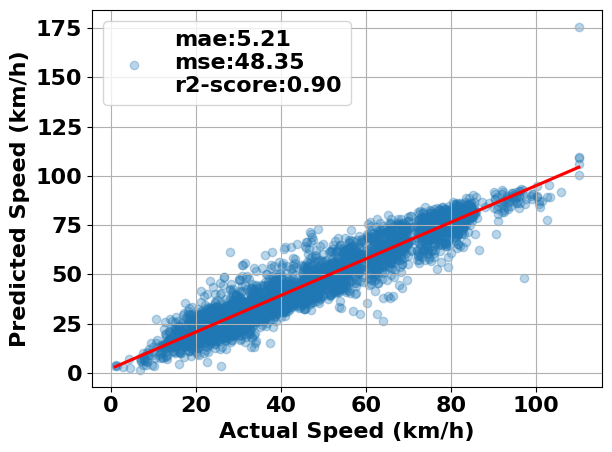

In [14]:
sns.regplot(x=speed_test,y=pred,label='mae:{:.2f}\nmse:{:.2f}\nr2-score:{:.2f}'.format(mae,mse,r2),
            line_kws={'color':'red'},scatter_kws={'alpha':0.3})
plt.xlabel("Actual Speed (km/h)")
plt.ylabel("Predicted Speed (km/h)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./Output/tr2019_test_r2.png")

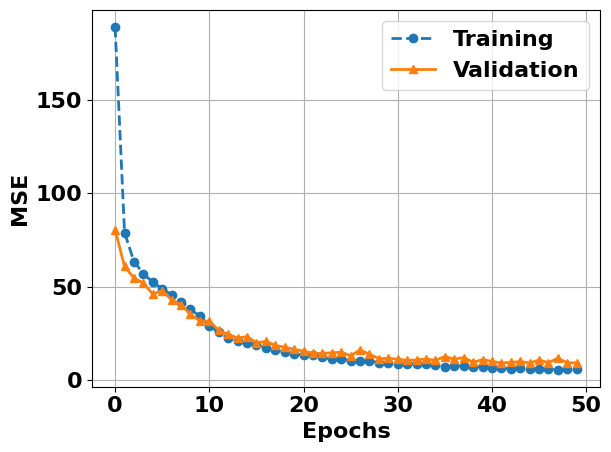

In [15]:
plt.plot(training.history["mse"],lw=2,ls='--',marker='o',label="Training")
plt.plot(training.history["val_mse"],lw=2,ls='-',marker='^',label='Validation')
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./Output/tr2019_mse.png")

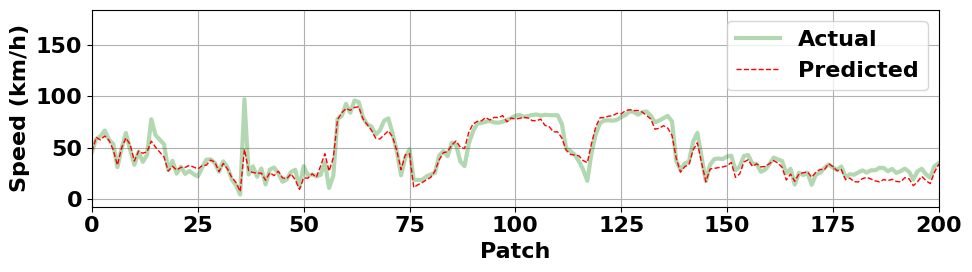

In [16]:
plt.figure(figsize=(10,3))
plt.plot(speed_test,lw=3,ls='-',color='g',alpha=0.3,label='Actual')
plt.plot(pred,lw=1,ls='--',color='r',label='Predicted')
plt.xlabel("Patch")
plt.ylabel("Speed (km/h)")
plt.xlim(0,200)
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("./Output/tr2019_deviations.png")